![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Names with a Conditional Character-Level RNN

[In the last tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify names into their language of origin. This time we'll turn around and generate names from languages. This model will improve upon the RNN we used to [generate Shakespeare one character at a time](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb) by adding another input (representing the language) so we can specify what kind of name to generate.

```
> python generate.py Russian
Rovakov
Uantov
Shavakov

> python generate.py German
Gerren
Ereng
Rosher

> python generate.py Spanish
Salla
Parer
Allan

> python generate.py Chinese
Chan
Hang
Iun
```

Being able to "prime" the generator with a specific category brings us a step closer to the [Sequence to Sequence model](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) used for machine translation.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

I also suggest the previous tutorials:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) for using an RNN to classify text into categories
* [Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb) for using an RNN to generate one character at a time

# Preparing the Data

See [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) for more detail - we're using the exact same dataset. In short, there are a bunch of plain text files `data/names/[Language].txt` with a name per line. We split lines into an array, convert Unicode to ASCII, and end up with a dictionary `{language: [names ...]}`.

In [1]:
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii("O'Néàl"))

O'Neal


In [2]:
# Read a file and split into lines
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('../data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


# Creating the Network

This network extends [the last tutorial's RNN](#Creating-the-Network) with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer `o2o` (after combining hidden and output) to give it more muscle to work with. There's also a dropout layer, which [randomly zeros parts of its input](https://arxiv.org/abs/1207.0580) with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

![](https://i.imgur.com/jzVrf7f.png)

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Preparing for Training

First of all, helper functions to get random pairs of (category, line):

In [4]:
import random

# Get a random category and random line from that category
def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be `(category, current letter, hidden state)` and the outputs will be `(next letter, next hidden state)`. So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for `"ABCD<EOS>"` we would create ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot tensor](https://en.wikipedia.org/wiki/One-hot) of size `<1 x n_categories>`. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [5]:
# One-hot vector for category
def make_category_input(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return Variable(tensor)

# One-hot matrix of first to last letters (not including EOS) for input
def make_chars_input(chars):
    tensor = torch.zeros(len(chars), n_letters)
    for ci in range(len(chars)):
        char = chars[ci]
        tensor[ci][all_letters.find(char)] = 1
    tensor = tensor.view(-1, 1, n_letters)
    return Variable(tensor)

# LongTensor of second letter to end (EOS) for target
def make_target(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    tensor = torch.LongTensor(letter_indexes)
    return Variable(tensor)

For convenience during training we'll make a `random_training_set` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [6]:
# Make category, input, and target tensors from a random category, line pair
def random_training_set():
    category, line = random_training_pair()
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    line_target = make_target(line)
    return category_input, line_input, line_target

# Training the Network

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end. But don't ask me why initializing loss with 0 works.

In [7]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()
    optimizer.step()
    
    return output, loss.data[0] / input_line_tensor.size()[0]

To keep track of how long training takes I am adding a `time_since(t)` function which returns a human readable string:

In [8]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every `print_every` epochs, and keeping store of an average loss per `plot_every` epochs in `all_losses` for plotting later.

In [9]:
n_epochs = 100000
print_every = 5000
plot_every = 500
all_losses = []
loss_avg = 0 # Zero every plot_every epochs to keep a running average
learning_rate = 0.0005

rnn = RNN(n_letters, 128, n_letters)
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()

for epoch in range(1, n_epochs + 1):
    output, loss = train(*random_training_set())
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 28s (5000 5%) 1.8674
0m 53s (10000 10%) 2.4155
1m 20s (15000 15%) 3.4203
1m 45s (20000 20%) 1.3962
2m 12s (25000 25%) 1.7427
2m 38s (30000 30%) 2.9514
3m 4s (35000 35%) 2.8836
3m 31s (40000 40%) 1.6728
3m 57s (45000 45%) 2.5014
4m 22s (50000 50%) 1.9687
4m 48s (55000 55%) 1.5595
5m 16s (60000 60%) 2.3830
5m 43s (65000 65%) 1.5155
6m 10s (70000 70%) 1.7967
6m 37s (75000 75%) 1.8564
7m 3s (80000 80%) 1.9873
7m 30s (85000 85%) 1.9569
7m 56s (90000 90%) 1.7553
8m 22s (95000 95%) 2.3103
8m 48s (100000 100%) 1.7575


# Plotting the Network

Plotting the historical loss from all_losses shows the network learning:

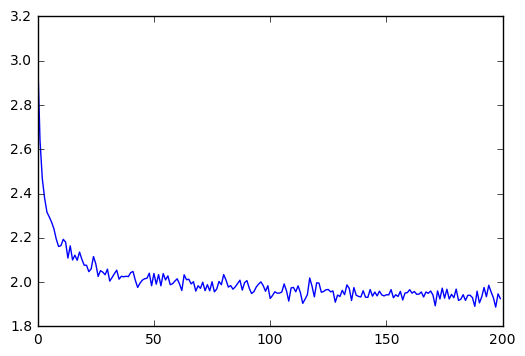

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state
* Create a string `output_str` with the starting letter
* Up to a maximum output length,
    * Feed the current letter to the network
    * Get the next letter from highest output, and next hidden state
    * If the letter is EOS, stop here
    * If a regular letter, add to `output_str` and continue
* Return the final name

*Note*: Rather than supplying a starting letter every time we generate, we could have trained with a "start of string" token and had the network choose its own starting letter.

In [13]:
max_length = 20

# Generate given a category and starting letter
def generate_one(category, start_char='A', temperature=0.5):
    category_input = make_category_input(category)
    chars_input = make_chars_input(start_char)
    hidden = rnn.init_hidden()

    output_str = start_char
    
    for i in range(max_length):
        output, hidden = rnn(category_input, chars_input[0], hidden)
        
        # Sample as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Stop at EOS, or add to output_str
        if top_i == EOS:
            break
        else:    
            char = all_letters[top_i]
            output_str += char
            chars_input = make_chars_input(char)

    return output_str

# Get multiple samples from one category and multiple starting letters
def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [14]:
generate('Russian', 'RUS')

Riberkov
Urtherdez
Shimanev


In [15]:
generate('German', 'GER')

Gomen
Ester
Ront


In [16]:
generate('Spanish', 'SPA')

Sandar
Per
Alvareza


In [17]:
generate('Chinese', 'CHI')

Cha
Hang
Ini


The final versions of the scripts [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/conditional-char-rnn) split the above code into a few files:

* `data.py` (loads files)
* `model.py` (defines the RNN)
* `train.py` (runs training)
* `generate.py` (runs `generate()` with command line arguments)

Run `train.py` to train and save the network.

Then run `generate.py` with a language to view generated names: 

```
$ python generate.py Russian
Alaskinimhovev
Beranivikh
Chamon
```

# Exercises

* Adjust the `temperature` argument to see how generation is affected 
* Try with a different dataset of category -> line, for example:
    * Fictional series -> Character name
    * Part of speech -> Word
    * Country -> City
* Use a "start of sentence" token so that sampling can be done without choosing a start letter
* Get better results with a bigger network

**Next**: [Translation with a Sequence to Sequence Network and Attention](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb)